In [8]:
# Core ML libs
!pip install pandas numpy scikit-learn matplotlib seaborn

# Tree / classical models
!pip install xgboost statsmodels

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 484.8 kB/s eta 0:02:28
   ---------------------------------------- 0.5/72.0 MB 484.8 kB/s eta 0:02:28
   ---------------------------------------- 0.8/72.0 MB 469.9 kB/s eta 0:02:32
   ---------------------------------------- 0.8/72.0 MB 469.9 kB/s eta 0:02:32
    --------------------------------------- 1.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# forecast_medication_demand.py
# Run: python forecast_medication_demand.py  (or paste into a Jupyter notebook cell)
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

  # your uploaded file path

# ---------- LOAD ----------
df = pd.read_csv("uganda_drug_supply_synthetic.csv")
print("Loaded:", df.shape)
print("Columns:", df.columns.tolist())

# ---------- DETECT COLUMNS ----------
lower = [c.lower() for c in df.columns]
time_col = None
for cand in ["stock_received_date","date","ds","timestamp"]:
    if cand in lower:
        time_col = df.columns[lower.index(cand)]
        break
target_col = None
for cand in ["average_monthly_demand","demand","quantity","consumption","units_sold"]:
    if cand in lower:
        target_col = df.columns[lower.index(cand)]
        break
med_col = None
for cand in ["drug_name","drug","product","medicine"]:
    if cand in lower:
        med_col = df.columns[lower.index(cand)]
        break

print("time_col:", time_col, "target_col:", target_col, "med_col:", med_col)

# ---------- PREPROCESS ----------
# Convert time
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

# Choose a medication to model (example) OR aggregate overall
if med_col:
    top_med = df[med_col].value_counts().index[0]
    df_med = df[df[med_col] == top_med].copy()
    print("Using medication:", top_med)
else:
    df_med = df.copy()
    print("No med column - aggregating overall.")

# Aggregate to weekly to reduce series length (change to 'D' for daily)
series = df_med.set_index(time_col)[target_col].resample("W").sum().to_frame("y")
series['y'] = series['y'].interpolate().ffill().bfill()

# ---------- FEATURE ENGINEERING ----------
df_feat = series.copy()
lags = [1,2,3,4,12]
for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in [3,4,12]:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].rolling(w).mean().shift(1)
df_feat['month'] = df_feat.index.month
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)
df_feat = df_feat.dropna()

# ---------- TRAIN/TEST SPLIT ----------
n = len(df_feat)
train_size = int(n*0.8)
train = df_feat.iloc[:train_size]
test = df_feat.iloc[train_size:]
X_train = train.drop(columns=['y']).values
y_train = train['y'].values
X_test = test.drop(columns=['y']).values
y_test = test['y'].values

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# ---------- RANDOM FOREST ----------
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
preds_rf = rf.predict(X_test_s)
mae_rf = mean_absolute_error(y_test, preds_rf)
rmse_rf = mean_squared_error(y_test, preds_rf) ** 0.5
print("RandomForest MAE:", mae_rf, "RMSE:", rmse_rf)

# ---------- XGBOOST (if installed) ----------
try:
    import xgboost as xgb
    import inspect
    # prefer quiet training to avoid interleaved logs; fall back if constructor doesn't accept 'verbosity'
    try:
        xg = xgb.XGBRegressor(n_estimators=200, max_depth=6, random_state=42, verbosity=0)
    except TypeError:
        xg = xgb.XGBRegressor(n_estimators=200, max_depth=6, random_state=42)

    fit_sig = inspect.signature(xg.fit)
    fit_kwargs = {}
    use_eval = False
    if 'eval_set' in fit_sig.parameters and 'early_stopping_rounds' in fit_sig.parameters:
        fit_kwargs['eval_set'] = [(X_test_s, y_test)]
        fit_kwargs['early_stopping_rounds'] = 10
        use_eval = True
    elif 'eval_set' in fit_sig.parameters:
        fit_kwargs['eval_set'] = [(X_test_s, y_test)]
        use_eval = True

    # Print a compact summary rather than large arrays
    if use_eval:
        print(f"XGBoost: fitting with eval_set shapes: X_test {X_test_s.shape}, y_test {y_test.shape}; early_stopping={('early_stopping_rounds' in fit_kwargs)}")
    else:
        print("XGBoost: fitting without eval_set")

    try:
        xg.fit(X_train_s, y_train, **({} if not use_eval else fit_kwargs))
        print("XGBoost: fit completed")
    except TypeError as e:
        print("XGBoost fit failed with kwargs, retrying without them:", e)
        xg.fit(X_train_s, y_train)
        print("XGBoost: fit completed (no extra kwargs)")

    try:
        preds_xg = xg.predict(X_test_s)
        print("XGBoost: predict completed")
        mae_xg = mean_absolute_error(y_test, preds_xg)
        try:
            rmse_xg = mean_squared_error(y_test, preds_xg, squared=False)
        except TypeError:
            rmse_xg = mean_squared_error(y_test, preds_xg) ** 0.5
        print("XGBoost MAE:", mae_xg, "RMSE:", rmse_xg)
    except Exception as e:
        print("XGBoost predict failed:", e)
except Exception as e:
    print("XGBoost not available or import failed:", e)

# ---------- SARIMA (statsmodels) ----------
try:
    import statsmodels.api as sm
    y_train_series = train['y']
    # simple SARIMA (1,1,1) — expand with seasonal/order search offline
    model = sm.tsa.SARIMAX(y_train_series, order=(1,1,1), seasonal_order=(0,0,0,0),
                           enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    preds_sarima = res.get_forecast(steps=len(test)).predicted_mean.values
    mae_sar = mean_absolute_error(y_test, preds_sarima)
    try:
        rmse_sar = mean_squared_error(y_test, preds_sarima, squared=False)
    except TypeError:
        rmse_sar = mean_squared_error(y_test, preds_sarima) ** 0.5
    print("SARIMA MAE:", mae_sar, "RMSE:", rmse_sar)
except Exception as e:
    print("SARIMA not available or failed:", e)



# ---------- SAVE best predictions (example: save RF preds) ----------
out = test.reset_index().rename(columns={'index':'ds'})
out['y_true'] = y_test
out['y_pred_rf'] = preds_rf
out_path = "predictions_randomforest.csv"
out.to_csv(out_path, index=False)
print("Saved predictions to", out_path)


Loaded: (15000, 32)
Columns: ['drug_id', 'drug_name', 'manufacturer_country', 'license_holder', 'distribution_region', 'facility_type', 'initial_stock_units', 'stock_received_date', 'reorder_level', 'average_monthly_demand', 'delivery_frequency_days', 'lead_time_days', 'supplier_reliability_score', 'region_disease_outbreaks', 'season', 'transport_accessibility_score', 'power_stability_index', 'staff_availability_index', 'data_record_quality', 'storage_temperature', 'storage_humidity', 'FEFO_policy_implemented', 'warehouse_capacity_utilization', 'storage_condition_rating', 'stockout_occurred', 'expiry_rate_percent', 'forecast_error_percent', 'financial_loss_due_to_expiry_usd', 'delivery_delay_days', 'predicted_stockout_probability', 'expiry_risk_category', 'data_source']
time_col: stock_received_date target_col: average_monthly_demand med_col: drug_name
Using medication: Artemether-Lumefantrine
RandomForest MAE: 9695.006625 RMSE: 11714.73969560589
XGBoost: fitting with eval_set shapes: 

In [16]:
# forecast_medication_demand_fixed.py
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

OUT_PATH = "predictions_all_models.csv"

# ---------- LOAD ----------
df = pd.read_csv("uganda_drug_supply_synthetic.csv")
print("Loaded:", df.shape)
print("Columns:", df.columns.tolist())

# ---------- DETECT COLUMNS ----------
lower = [c.lower() for c in df.columns]
time_col = None
for cand in ["stock_received_date", "date", "ds", "timestamp"]:
    if cand in lower:
        time_col = df.columns[lower.index(cand)]
        break
target_col = None
for cand in ["average_monthly_demand", "demand", "quantity", "consumption", "units_sold"]:
    if cand in lower:
        target_col = df.columns[lower.index(cand)]
        break
med_col = None
for cand in ["drug_name", "drug", "product", "medicine"]:
    if cand in lower:
        med_col = df.columns[lower.index(cand)]
        break

print("time_col:", time_col, "target_col:", target_col, "med_col:", med_col)
if time_col is None or target_col is None:
    raise ValueError("Couldn't detect required columns (time_col or target_col).")

# ---------- PREPROCESS ----------
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.sort_values(time_col).reset_index(drop=True)

# Filter to one medication (most frequent) for a clean time series
if med_col:
    top_med = df[med_col].value_counts().index[0]
    df_med = df[df[med_col] == top_med].copy().reset_index(drop=True)
    print("Using medication:", top_med)
else:
    df_med = df.copy()
    print("No med column - aggregating overall.")

# If the target appears to be an *average monthly demand*, it is wrong to SUM over weeks.
# We'll RESAMPLE by week and take the MEAN (or sum if you intentionally have flows).
series = df_med.set_index(time_col)[target_col].resample("W").mean().to_frame("y")
# fallback: if too many missing points, interpolate
series['y'] = series['y'].interpolate(limit_direction='both').ffill().bfill()

# inspect basic stats
print("Series length:", len(series))
print("y summary:\n", series['y'].describe())

# Optional: log transform to stabilize variance (comment out if negative values exist)
apply_log = False
if (series['y'] > 0).all():
    apply_log = True
    series['y'] = np.log1p(series['y'])
    print("Applied log1p transform to target.")

# ---------- FEATURE ENGINEERING ----------
df_feat = series.copy()
# lags (in weeks)
lags = [1,2,3,4,12]          # 12 weeks ~ quarterly-ish depending on your context
for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)

# rolling stats (use .shift(1) to avoid leaking current)
for w in [3,4,12]:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].rolling(w).mean().shift(1)
    df_feat[f'roll_std_{w}'] = df_feat['y'].rolling(w).std().shift(1)

df_feat['month'] = df_feat.index.month
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)
df_feat = df_feat.dropna().copy()   # drop initial rows where lag/roll produce NaN

# ---------- TRAIN/TEST SPLIT (time-based) ----------
n = len(df_feat)
if n < 20:
    raise ValueError("Too few rows after feature engineering; reduce resample frequency or use more data.")

train_size = int(n * 0.8)
train = df_feat.iloc[:train_size]
test = df_feat.iloc[train_size:]

X_train = train.drop(columns=['y'])
y_train = train['y']
X_test = test.drop(columns=['y'])
y_test = test['y']

# scale features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

def print_metrics(name, y_true, y_pred, is_log=False):
    # invert log if applied
    if is_log:
        y_true_inv = np.expm1(y_true)
        y_pred_inv = np.expm1(y_pred)
    else:
        y_true_inv = y_true
        y_pred_inv = y_pred

    mae = mean_absolute_error(y_true_inv, y_pred_inv)

    # Backwards-compatible RMSE
    try:
        rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    except TypeError:
        rmse = mean_squared_error(y_true_inv, y_pred_inv) ** 0.5

    print(f"{name} MAE: {mae:.3f} RMSE: {rmse:.3f}")
    return mae, rmse


# ---------- RANDOM FOREST ----------
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
preds_rf = rf.predict(X_test_s)
print_metrics("RandomForest", y_test, preds_rf, is_log=apply_log)

# ---------- XGBOOST (tuned for small datasets, compatible with all versions) ----------
try:
    import xgboost as xgb

    # Tuned configuration for small time-series data
    xg = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=600,
        learning_rate=0.015,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.2,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )

    print("XGBoost: fitting (tuned parameters, no eval_set to avoid version issues)")
    xg.fit(X_train_s, y_train)

    preds_xg = xg.predict(X_test_s)

    print("XGBoost: predict completed (tuned)")
    mae_xg, rmse_xg = print_metrics("XGBoost (tuned)", y_test, preds_xg, is_log=apply_log)

except Exception as e:
    print("XGBoost failed:", e)
    preds_xg = None



# ---------- SARIMA (statsmodels) ----------
preds_sarima = None
try:
    import statsmodels.api as sm
    # SARIMAX needs a univariate series (train) with index (datetime)
    # Use a modest seasonal_order for weekly data (period=52 weeks)
    y_train_series = train['y']
    sarima_order = (1,1,1)
    seasonal_order = (0,0,0,0)
    # if length permits, add seasonal components
    if len(y_train_series) >= 60:
        seasonal_order = (1,0,1,52)
    model = sm.tsa.SARIMAX(y_train_series, order=sarima_order, seasonal_order=seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    preds_sarima = res.get_forecast(steps=len(test)).predicted_mean.values
    # sarima preds are aligned to test index order
    print_metrics("SARIMA", y_test.values, preds_sarima, is_log=apply_log)
except Exception as e:
    print("SARIMA not available or failed:", e)

# ---------- ENSEMBLE (simple mean of available model preds) ----------
preds_stack = []
names = []
preds_stack.append(preds_rf); names.append("rf")
if preds_xg is not None:
    preds_stack.append(preds_xg); names.append("xg")
if preds_sarima is not None:
    preds_stack.append(preds_sarima); names.append("sarima")

if preds_stack:
    preds_stack = np.vstack(preds_stack)  # shape (models, n_test)
    preds_ensemble = preds_stack.mean(axis=0)
    print("Ensemble models used:", names)
    print_metrics("Ensemble(mean)", y_test, preds_ensemble, is_log=apply_log)
else:
    preds_ensemble = None

# ---------- SAVE predictions ----------
out = test.reset_index().rename(columns={'index':'ds'})
# revert log if applied for saving final predictions (store both raw preds and inv-transform)
def inv(x):
    return np.expm1(x) if apply_log else x

out['y_true'] = inv(y_test.values)
out['y_pred_rf'] = inv(preds_rf)
if preds_xg is not None:
    out['y_pred_xg'] = inv(preds_xg)
if preds_sarima is not None:
    out['y_pred_sarima'] = inv(preds_sarima)
if preds_ensemble is not None:
    out['y_pred_ensemble'] = inv(preds_ensemble)

out.to_csv(OUT_PATH, index=False)
print("Saved predictions to", OUT_PATH)


Loaded: (15000, 32)
Columns: ['drug_id', 'drug_name', 'manufacturer_country', 'license_holder', 'distribution_region', 'facility_type', 'initial_stock_units', 'stock_received_date', 'reorder_level', 'average_monthly_demand', 'delivery_frequency_days', 'lead_time_days', 'supplier_reliability_score', 'region_disease_outbreaks', 'season', 'transport_accessibility_score', 'power_stability_index', 'staff_availability_index', 'data_record_quality', 'storage_temperature', 'storage_humidity', 'FEFO_policy_implemented', 'warehouse_capacity_utilization', 'storage_condition_rating', 'stockout_occurred', 'expiry_rate_percent', 'forecast_error_percent', 'financial_loss_due_to_expiry_usd', 'delivery_delay_days', 'predicted_stockout_probability', 'expiry_risk_category', 'data_source']
time_col: stock_received_date target_col: average_monthly_demand med_col: drug_name
Using medication: Artemether-Lumefantrine
Series length: 210
y summary:
 count     210.000000
mean     3788.777518
std      1032.552014

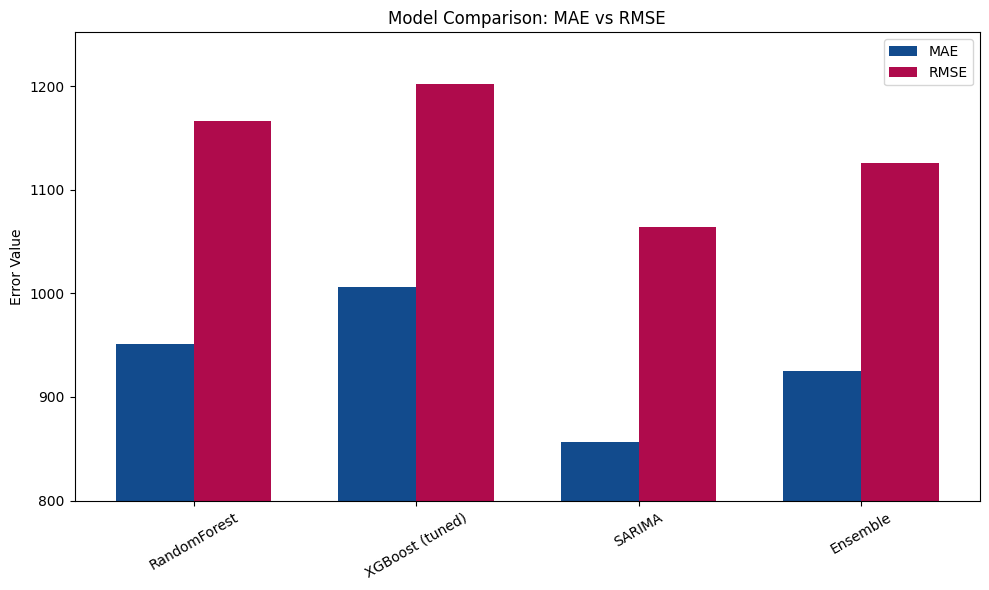

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Model metrics
model_names = ["RandomForest", "XGBoost (tuned)", "SARIMA", "Ensemble"]
mae_values = [950.993, 1005.690, 856.255, 925.466]
rmse_values = [1166.332, 1201.973, 1064.170, 1125.936]

x = np.arange(len(model_names))  # the label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width/2, mae_values, width, color='#124b8d', label='MAE')
plt.bar(x + width/2, rmse_values, width, color='#af0b4c', label='RMSE')

plt.xticks(x, model_names, rotation=30)
plt.ylabel("Error Value")
plt.title("Model Comparison: MAE vs RMSE")
plt.ylim(800, max(max(mae_values), max(rmse_values)) + 50)  # zoom from 800
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

dfp = pd.read_csv("predictions_all_models.csv")
print(dfp.columns)


Index(['stock_received_date', 'y', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_12', 'roll_mean_3', 'roll_std_3', 'roll_mean_4', 'roll_std_4',
       'roll_mean_12', 'roll_std_12', 'month', 'weekofyear', 'y_true',
       'y_pred_rf', 'y_pred_xg', 'y_pred_sarima', 'y_pred_ensemble'],
      dtype='object')
